In [1105]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [1106]:
im = cv2.imread('./images/mountain.jpg', cv2.IMREAD_COLOR)
im_gray = cv2.imread('./images/mountain.jpg', cv2.IMREAD_GRAYSCALE)

In [1107]:
im_color = cv2.resize(im, (0,0), fx=1/2, fy=1/2)
# im_color = im

In [1108]:
def get_gauss_pyramid(im, l=4, sub=2, smoothing=1.0):
    res = [im]
    
    for i in range(l):
        tmp = cv2.GaussianBlur(im, (0,0), smoothing)
        tmp = cv2.resize(im, (0,0), fx=1/sub, fy=1/sub)
        res.append(tmp)
        im = tmp
    
    return res

In [1109]:
def window_func(x, y, s):
    return np.exp(-(x**2 + y**2)/(2*s**2))

In [1110]:
def get_harris_matrix(im, si=1.5, sd=1, k=0.04):
    h, w = im.shape[0], im.shape[1]
    prod = []
    
    Iy, Ix = np.gradient(im)
    
    Ix2 = np.square(Ix)
    Iy2 = np.square(Iy)
    Ixy = Ix * Iy
    
    Sx2 = cv2.GaussianBlur(Ix2, (3, 3), si)
    Sy2 = cv2.GaussianBlur(Iy2, (3, 3), si)
    Sxy = cv2.GaussianBlur(Ixy, (3, 3), si)
    
    detM = (Sx2 * Sy2) - (np.square(Sxy))
    trM = Sx2 + Sy2

    R = detM - k * (np.square(trM))
        
    return R, Sx2, Sy2, Sxy

In [1111]:
def get_max_R(R, threshold=0.1):
    localMax = np.ones(R.shape, dtype=np.uint8)
    localMax[R <= np.max(R) * threshold] = 0
    
    maxima = []
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if localMax[i, j] == 1:
                maxima.append((j, i))
    
    return maxima

In [1112]:
def get_feature_points(im, output_im):
    R, Sx2, Sy2, Sxy = get_harris_matrix(cur_img)
    maxima = get_max_R(R)
    
    for p in maxima:
        output_im = cv2.circle(output_im, p, 1, (0, 0, 255), 1)
    
    return maxima, output_im

In [1113]:
def get_orientations(M, so=4.5):
    Iy, Ix = np.gradient(M)
    Sy, Sx = cv2.GaussianBlur(Iy, (3, 3), so), cv2.GaussianBlur(Ix, (3, 3), so)
    
    res = []
    
    for i in range(Sy.shape[0]):
        tmp = []
        for j in range(Sy.shape[1]):
            v = np.array([Sx[i, j], Sy[i, j]])
            v_norm = np.linalg.norm(v)
            if v_norm == 0:
                tmp.append(np.array([0.0, 0.0]))
            else:
                tmp.append(v / v_norm)
        res.append(tmp)
    
    return np.array(res)

In [1114]:
def get_angles(im):
    Iy, Ix = np.gradient(im)
    angles = np.arctan(Iy / (Ix + 1e-8)) * (180 / np.pi)
    angles[Ix < 0] += 180
    angles = (angles + 360) % 360
    
    return angles

In [1115]:
im_pyramid = get_gauss_pyramid(im_gray)

In [1116]:
cur_img = im_pyramid[1]

In [1117]:
test_img = cur_img.copy()

In [1118]:
fp, fp_img = get_feature_points(cur_img, test_img)

In [1119]:
angles = get_angles(cur_img).astype(int)

In [1120]:
z = get_orientations(cur_img)

In [1121]:
def draw_angled_rect(im, p, a, s=30):
#     slope = a[1]/a[0 ]
    a = (abs(a[0]), abs(a[1]))
    a2 = ((a[0] + 3*np.pi / 4), (a[1] + 3*np.pi / 4))
    a3 = ((a[0] + 5*np.pi / 4), (a[1] + 5*np.pi / 4))
    a4 = ((a[0] + 7*np.pi / 4), (a[1] + 7*np.pi / 4))

    a1, a2, a3, a4 = np.radians(45), np.radians(135), np.radians(225), np.radians(315)
    
    x0, y0 = p[0], p[1]
    x1, y1 = p[0]+s, p[1]+s
    x2, y2 = p[0]+s, p[1]-s
    x3, y3 = p[0]-s, p[1]-s
    x4, y4 = p[0]-s, p[1]+s
    
    nx1 = int(((x1 - x0) * np.cos(a1)) - ((y1 - y0) * np.sin(a1)) + x0);
    ny1 = int(((x1 - x0) * np.sin(a1)) + ((y1 - y0) * np.cos(a1)) + y0);
    
    nx2 = int(((x2 - x0) * np.cos(a2)) - ((y2 - y0) * np.sin(a2)) + x0);
    ny2 = int(((x2 - x0) * np.sin(a2)) + ((y2 - y0) * np.cos(a2)) + y0);
    
    nx3 = int(((x3 - x0) * np.cos(a3)) - ((y3 - y0) * np.sin(a3)) + x0);
    ny3 = int(((x3 - x0) * np.sin(a3)) + ((y3 - y0) * np.cos(a3)) + y0);
    
    nx4 = int(((x4 - x0) * np.cos(a4)) - ((y4 - y0) * np.sin(a4)) + x0);
    ny4 = int(((x4 - x0) * np.sin(a4)) + ((y4 - y0) * np.cos(a4)) + y0);
    
#     x1 = int(((x1 - x0) * a[0]) - ((y1 - y0) * a[1]) + x0);
#     y1 = int(((x1 - x0) * a[1]) + ((y1 - y0) * a[0]) + y0);
    
#     x2 = int(((x2 - x0) * a2[0]) - ((y2 - y0) * a2[1]) + x0);
#     y2 = int(((x2 - x0) * a2[1]) + ((y2 - y0) * a2[0]) + y0);
    
#     x3 = int(((x3 - x0) * a3[0]) - ((y3 - y0) * a3[1]) + x0);
#     y3 = int(((x3 - x0) * a3[1]) + ((y3 - y0) * a3[0]) + y0);
    
#     x4 = int(((x4 - x0) * a[0]) - ((y4 - y0) * a4[1]) + x0);
#     y4 = int(((x4 - x0) * a[1]) + ((y4 - y0) * a4[0]) + y0);
#     x1 = int(p[0] + s * (angle[0] + np.pi / 4))
#     y1 = int(p[1] + s * (angle[1] + np.pi / 4))
    
#     x2 = int(p[0] + s * np.cos(int(np.degrees((np.arccos(angle[0])+(3*np.pi / 4))))%360))
#     y2 = int(p[1] + s * np.sin(int(np.degrees((np.arcsin(angle[1])+(3*np.pi / 4))))%360))
    
#     x3 = int(p[0] + s * np.cos(int(np.degrees((np.arccos(angle[0])+(5*np.pi / 4))))%360))
#     y3 = int(p[1] + s * np.sin(int(np.degrees((np.arcsin(angle[1])+(5*np.pi / 4))))%360))
    
#     x4 = int(p[0] + s * (angle[0] + 7*np.pi / 4))
#     y4 = int(p[1] + s * (angle[1] + 7*np.pi / 4))
#     output_im = cv2.circle(im, (x1, y1), 2, (255, 0, 0), 2)
#     output_im = cv2.circle(im, (x2, y2), 2, (255, 0, 0), 2)
#     output_im = cv2.circle(im, (x3, y3), 2, (255, 0, 0), 2)
#     output_im = cv2.circle(im, (x4, y4), 2, (255, 0, 0), 2)

    output_im = cv2.circle(im, (nx1, ny1), 2, (255, 0, 0), 2)
    output_im = cv2.circle(im, (nx2, ny2), 2, (255, 0, 0), 2)
    output_im = cv2.circle(im, (nx3, ny3), 2, (255, 0, 0), 2)
    output_im = cv2.circle(im, (nx4, ny4), 2, (255, 0, 0), 2)
    
    
#     cv2.line(im, (nx1, ny1), (nx2, ny2), (255, 0, 0), thickness=1, lineType=1)
#     cv2.line(im, (nx2, ny2), (nx3, ny3), (255, 0, 0), thickness=1, lineType=1)
#     cv2.line(im, (nx3, ny3), (nx4, ny4), (255, 0, 0), thickness=1, lineType=1)
#     cv2.line(im, (nx4, ny4), (nx1, ny1), (255, 0, 0), thickness=1, lineType=1)

    return

In [1122]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    print(rot_mat)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

In [1123]:
rot_im = rotate_image(im_color, 45)

[[  0.70710678   0.70710678  98.81592744]
 [ -0.70710678   0.70710678 241.56275221]]


In [1124]:
cur_img.shape

(512, 682)

In [1125]:
cur_img.shape[1::-1]

(682, 512)

In [1126]:
def get_patch(image, p, angle, s=8):
    p = np.array([[p[1]],[p[0]]])
    print(p)
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_img = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    cv2.imwrite("./images/rotated_img.png", rot_img)
    A = [
        [rot_mat[0][0], rot_mat[0][1]],
        [rot_mat[1][0], rot_mat[1][1]],
        ]
    
    B = [
        [rot_mat[0][2]],
        [rot_mat[1][2]],
    ]
    new_p = np.matmul(A, p)
    print(new_p)
    new_p = new_p + B
    print(new_p)
#     print(p)
#     print(A)
#     print(B)
    new_i = int(new_p[0])
    new_j = int(new_p[1])
    
    res = []
    r = int(s/2)
    for i in range(-r, r, 1):
        tmp = []
        for j in range(-r, r, 1):
#             tmp.append(rot_img[p[1][0]+j, p[0][0]+i])
            tmp.append(rot_img[new_j+j, new_i+i])
        res.append(tmp)
    return np.array(res)

True

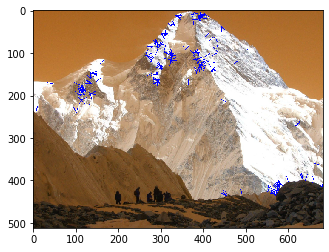

In [1127]:
for p in fp:
    angle = z[p[1], p[0]]
    x2 = int(p[0] + 15 * angle[0])
    y2 = int(p[1] + 15 * angle[1])
#     output_im = cv2.circle(im_color, (x2, y2), 2, (0, 0, 255), 2)
        
#     draw_angled_rect(im_color, p, z[p[1], p[0]])
    
#     break
    cv2.line(im_color, p, (x2, y2), (0, 0, 255), thickness=1, lineType=1)
    
    x2 = int(p[0] + 8 * (angle[0] + np.pi / 4))
    y2 = int(p[1] + 8 * (angle[1] + np.pi / 4))
    
#     cv2.line(im_color, p, (x2, y2), (255, 0, 0), thickness=1, lineType=1)
# im_color[fp[2][0], fp[2][1]] = [0, 0, 255]
plt.imshow(im_color)
cv2.imwrite("./images/test.png", im_color)

In [1128]:
# img = cv2.imread('./images/test.png', cv2.IMREAD_COLOR)

In [1144]:
test_p = fp[34]
angle = angles[test_p[1], test_p[0]]

In [1145]:
tim = cv2.imread('./images/mountain.jpg', cv2.IMREAD_COLOR)
img = cv2.resize(im, (0,0), fx=1/2, fy=1/2)
# img[test_p[0], test_p[1]] = [0, 0, 255]
img = cv2.circle(img, (test_p[1], test_p[0]), 2, (0, 0, 255), 2)

In [1148]:
test = get_patch(img, test_p, angle, 8)

[[ 32]
 [318]]
[[-179.8930377 ]
 [ 264.17133642]]
[[ 64.43943528]
 [104.87338408]]


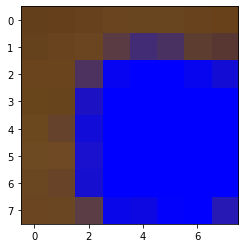

In [1149]:
plt.imshow(test)

In [1150]:
cv2.imwrite("./images/rot_test.png", test)

True